# Deep Learning Hands-On Lab

This is the Deep Learning part of the hands-on. We will work with the fashion MIST.

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

The very first thing you do is to import your libraries that are required to build your machine learning pipeline. In the previous part you learned about libraries such as Pandas or Seaborn.

In this part we will use the Deep Learning framework Tensorflow. 

TensorFlow is a free and open-source software library for dataflow and differentiable programming across a range of tasks. It is a symbolic math library, and is also used for machine learning applications such as neural networks.It is used for both research and production at Google

TensorFlow was developed by the Google Brain team for internal Google use. It was released under the Apache License 2.0 on November 9, 2015.

Tensorflow can be used in Python, JavaScript, C++ and Java.

We will use tensorflow by using the keras framework which uses tensorflow as the backend. 

Keras is an open-source neural-network library written in Python. It is capable of running on top of TensorFlow, Microsoft Cognitive Toolkit, Theano, or PlaidML.[1][2] Designed to enable fast experimentation with deep neural networks, it focuses on being user-friendly, modular, and extensible. It was developed as part of the research effort of project ONEIROS (Open-ended Neuro-Electronic Intelligent Robot Operating System),[3] and its primary author and maintainer is François Chollet, a Google engineer. Chollet also is the author of the XCeption deep neural network model[4].

In 2017, Google's TensorFlow team decided to support Keras in TensorFlow's core library.[5] Chollet explained that Keras was conceived to be an interface rather than a standalone machine learning framework. It offers a higher-level, more intuitive set of abstractions that make it easy to develop deep learning models regardless of the computational backend used.[6] Microsoft added a CNTK backend to Keras as well, available as of CNTK v2.0.[7][8]


## Import Libraries

In [38]:
import filecmp
import oci
from oci.object_storage.models import CreateBucketDetails
import os
import pandas as pd
import io
from PIL import Image
from io import StringIO
import cx_Oracle
import gzip

In [39]:
%matplotlib inline
import numpy as np
np.random.seed(1)

import tensorflow as tf
# WARNING: In TensorFlow 2.0 doesn't exist 
#tf.random.set_random_seed(2)

from tensorflow import keras
from tensorflow.keras import preprocessing

from tensorflow.keras.utils import get_file

import matplotlib.pyplot as plt

print("TensorFlow version: ", tf.__version__)
print("tensorflow.keras version: ", keras.__version__)
print("numpy version: ", np.__version__)

TensorFlow version:  2.0.0-rc0
tensorflow.keras version:  2.2.4-tf
numpy version:  1.16.4


# Object Storage

Same procedure as in the first Notebook.

We can pull the images from the object storage and use them for predictions. 

In [40]:
config = oci.config.from_file(".oci/config", "DEFAULT")
identity = oci.identity.IdentityClient(config)
user = identity.get_user(config["user"]).data
compartment_id = config["tenancy"]
object_storage = oci.object_storage.ObjectStorageClient(config)
namespace = object_storage.get_namespace().data
bucket_name = "machine_learning"
bucket = object_storage.get_bucket(namespace, bucket_name)

In [41]:
object_list = object_storage.list_objects(namespace, bucket_name)
for o in object_list.data.objects:
    print(o.name)

boston.csv
thshirt_1.jpg
trousers_1.jpg


In [42]:
object_name = "trousers_1.jpg"
#object_name = "newtest.txt"
#destination_dir = '/home/oracle/tmp'.format(object_name) 
get_obj = object_storage.get_object(namespace, bucket_name, object_name)
for chunktest in get_obj.data.raw.stream(1024 * 1024, decode_content=False):
    chunktest

We have to convert the bytes in order to open them as an image. 

In [43]:
imageStream = io.BytesIO(chunktest)
imageFile = Image.open(imageStream)
print(type(imageFile))
print(imageFile.size)

<class 'PIL.JpegImagePlugin.JpegImageFile'>
(202, 250)


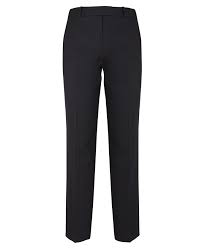

In [44]:
imageFile

## Fashion MINST

Let's load the data. We can pull the data directly from the keras repository. 

In [45]:
def get_data():
    with gzip.open('/data/notebooks/data/train-labels-idx1-ubyte.gz', 'rb') as lbpath:
        y_train = np.frombuffer(lbpath.read(), np.uint8, offset=8)

    with gzip.open('/data/notebooks/data/train-images-idx3-ubyte.gz', 'rb') as imgpath:
        x_train = np.frombuffer(
            imgpath.read(), np.uint8, offset=16).reshape(len(y_train), 28, 28)

    with gzip.open('/data/notebooks/data/t10k-labels-idx1-ubyte.gz', 'rb') as lbpath:
        y_test = np.frombuffer(lbpath.read(), np.uint8, offset=8)

    with gzip.open('/data/notebooks/data/t10k-images-idx3-ubyte.gz', 'rb') as imgpath:
        x_test = np.frombuffer(
            imgpath.read(), np.uint8, offset=16).reshape(len(y_test), 28, 28)
    return (x_train, y_train), (x_test, y_test)

(train_images, train_labels), (test_images, test_labels) = get_data()

Those are the various categories, which can be classified.

In [46]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

The shape tells us that our pictures have the dimension 28x28. 

In [47]:
print(train_images.shape)
#Each Label is between 0-9
train_labels
test_images.shape

(60000, 28, 28)


(10000, 28, 28)

In [48]:
train_images[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,
          1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          0,  36, 136, 127,  62,  54,   0,   0,   0,   1,   3,   4,   0,
          0,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,
          0, 102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   0,  12,
         10,   0],
       [  

We can also display those pictures, which are basically arrays. 

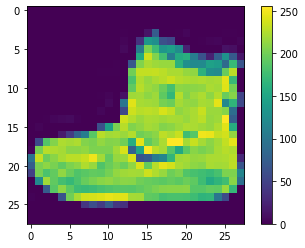

In [49]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()
#If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255.


In [50]:
train_images = train_images / 255.0
test_images = test_images / 255.0

Let's have a look at a variety of our training data / pictures. 

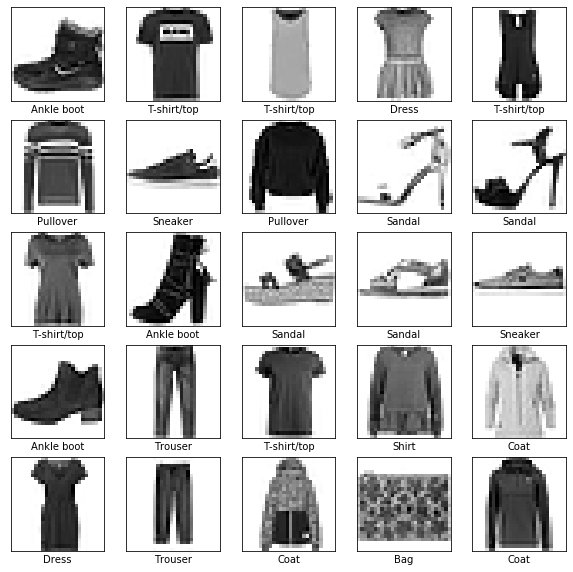

In [51]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## Create Model

We will utilize keras in order to build our model. 

Keras is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, CNTK, or Theano. It was developed with a focus on enabling fast experimentation.

In [52]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

The summary will show the definition of the model. This model has 3 layers and requires the input dimension 28x28, which our pictures have. 

In [53]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


Compiling will configure the model for training.

As our goal is to minimize the cost function by finding the optimized value for weights, we need to choose an optimizer and a loss function. 

In [54]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Fitting means training the model. We will pass the training images and labels (array form). Epochs defines that number of iterations. As the model is training, you will notice that the accuracy increases.

In [55]:
model.fit(train_images, train_labels, epochs=10)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 5s 75us/sample - loss: 0.4963 - accuracy: 0.8259
Epoch 2/10
60000/60000 [==============================] - 4s 69us/sample - loss: 0.3744 - accuracy: 0.8637
Epoch 3/10
60000/60000 [==============================] - 4s 69us/sample - loss: 0.3363 - accuracy: 0.8769
Epoch 4/10
60000/60000 [==============================] - 4s 69us/sample - loss: 0.3113 - accuracy: 0.8853
Epoch 5/10
60000/60000 [==============================] - 4s 69us/sample - loss: 0.2928 - accuracy: 0.8918
Epoch 6/10
60000/60000 [==============================] - 4s 69us/sample - loss: 0.2813 - accuracy: 0.8951
Epoch 7/10
60000/60000 [==============================] - 4s 69us/sample - loss: 0.2675 - accuracy: 0.9011
Epoch 8/10
60000/60000 [==============================] - 4s 69us/sample - loss: 0.2566 - accuracy: 0.9049
Epoch 9/10
60000/60000 [==============================] - 4s 69us/sample - loss: 0.2451 - accuracy: 0.9086
Epoch 10/10
60

## Test Model

Let's test the model with our test images.

In [56]:
#test_loss, test_acc = model.evaluate(test_images, test_labels)
#print('Test accuracy:', test_acc)

The accuracy seems to be fine as well. 

We can use the predict function to predict a bach or single images.

In [57]:
predictions = model.predict(test_images)
predictions[0]

array([5.8261264e-07, 6.2564931e-10, 2.2323060e-07, 4.3053274e-06,
       1.7198983e-09, 5.7025388e-04, 1.8258637e-05, 2.6753388e-02,
       1.5190142e-07, 9.7265291e-01], dtype=float32)

In [58]:
np.argmax(predictions[0])
#Model is most confident that it's an ankle boot. Let's see if it's correct

9

This test images seems to be ankle boots.

In [59]:
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

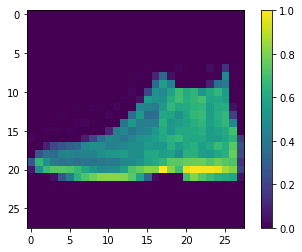

In [60]:
plt.figure()
plt.imshow(test_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

## Visualize Predictions

Let's utilize the two functions (one for plotting the images & one for plitting the values) below to create a grid of test images and their predictions. 

In [61]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img, cmap=plt.cm.binary)
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'green'
  else:
    color = 'red'
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)
def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('green')

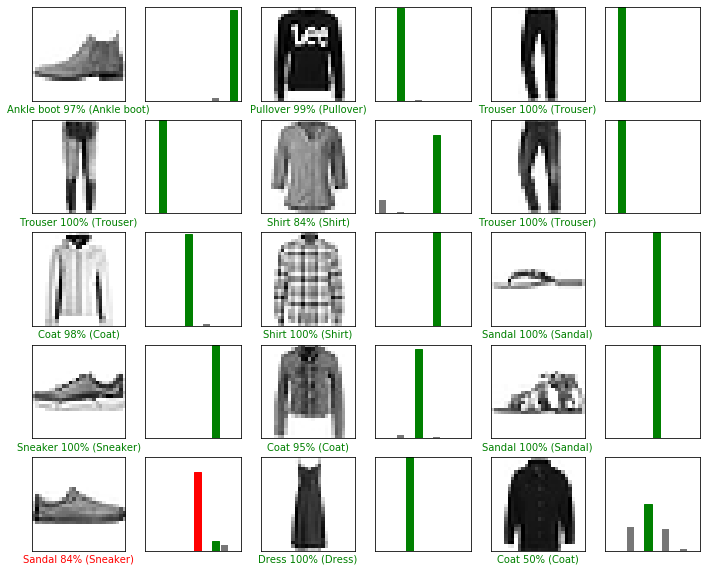

In [62]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)
plt.show()

## New Images

When we have an existing model, we can of course classify new images.

When doing that we have to make sure that the model can "understand" the new image. Therefore, we need to do some preprocessing. The image has to be read as an array, resized and potentially reshaped. 

In [63]:
import cv2
imga = cv2.imread('img/coat02.jpg')
imgz = np.invert(imga)
imgb = cv2.resize(imgz, (28, 28))
imgc = cv2.cvtColor(imgb, cv2.COLOR_BGR2GRAY)
#imgc = imgb
imgd = imgc.reshape((-1,28, 28))
imgd = imgd / 255

So above, we read the image and did some preprocessing. Let's have a look what the image looks like afterwards.

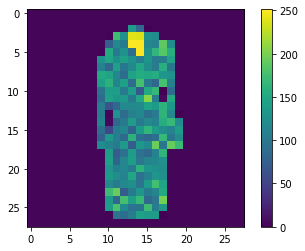

In [64]:
plt.figure()
plt.imshow(imgc)
plt.colorbar()
plt.grid(False)
plt.show()
#If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255.


In [65]:
testpredictions = model.predict(imgd)
np.argmax(testpredictions)

3

In [66]:
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [68]:
print("the end")

the end
